In [1]:
import os
import joblib
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown
import pandas as pd
import re

In [2]:
FIC_ENTRADA='prediccion_rnn_direct_LSTM1.joblib'
RUTA_FICHEROS = r"C:\Users\jaume\Documents\Proyecto\datos"

# Carga de datos

In [3]:
# Carga de datos
os.chdir(RUTA_FICHEROS)

with open(FIC_ENTRADA, 'rb') as file:
    data_dict = joblib.load(file)

# Recuperar DataFrame y scaler
df_results = data_dict['df_results'].copy()
#predictions_test = data_dict['predictions_test'].copy()

# Función para graficar las Learning Curves

In [4]:
def plot_all_learning_curves(df_results, n=4):
    """
    Grafica las curvas de aprendizaje (train_loss y val_loss) de cada experimento contenido en df_results.
    
    Cada gráfico tendrá un título con el siguiente formato:
    
      "Curvas de aprendizaje (entrenamiento X) (Mejor modelo)"
      "Cell: <cell_type>, latent_dim: <latent_dim>"
      "dropout: <dropout>, lr: <learning_rate>"
      "batch_size: <batch_size>"
    
    - "X" es el índice (clave) de la ejecución.
    - Se añade "(Mejor modelo)" si ese experimento tiene el menor valor en 'best_val_mse_eval'.
    
    Parámetros:
      - df_results: DataFrame con los resultados de cada ejecución (debe incluir las columnas mencionadas).
      - n: Número máximo de gráficos por fila (por defecto 4).
    """
    # Determinar el experimento "mejor" (el que tenga el menor best_val_mse_eval)
    best_index = df_results['best_val_mse_eval'].idxmin()
    
    num_experiments = len(df_results)
    n_cols = n
    n_rows = math.ceil(num_experiments / n_cols)
    
    # Crear la figura y los subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    # Convertir a un arreglo 1D para iterar fácilmente
    if n_rows * n_cols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    # Iterar sobre cada experimento
    for i, (idx, row) in enumerate(df_results.iterrows()):
        ax = axs[i]
        
        # Extraer la curva de aprendizaje: se asume que es un diccionario con 'loss' y 'val_loss'
        learning_curve = row['learning_curve']
        epochs = np.arange(1, len(learning_curve['loss']) + 1)
        
        # Graficar la pérdida de entrenamiento y de validación
        ax.plot(epochs, learning_curve['loss'], label="Train Loss")
        ax.plot(epochs, learning_curve['val_loss'], label="Val Loss")
        ax.set_xlabel("Épocas")
        ax.set_ylabel("Loss (MSE)")
        ax.legend(fontsize=8)
        
        # Construir el título:
        # Línea 1: Indicar el índice y si es el mejor modelo
        title_line1 = f"Curvas de aprendizaje (entrenamiento {idx})"
        if idx == best_index:
            title_line1 += " (Mejor modelo)"
        
        # Líneas siguientes: Parámetros de entrenamiento (máximo 2 por línea)
        params = [
            f"Cell: {row['cell_type']}",
            f"latent_dim: {row['latent_dim']}",
            f"dropout: {row['dropout']}",
            f"lr: {row['learning_rate']}",
            f"batch_size: {row['batch_size']}"
        ]
        param_lines = []
        for j in range(0, len(params), 2):
            line = ", ".join(params[j:j+2])
            param_lines.append(line)
        param_text = "\n".join(param_lines)
        
        full_title = title_line1 + "\n" + param_text
        ax.set_title(full_title, fontsize=10)
    
    # Desactivar los subplots que no se usan
    for k in range(i + 1, len(axs)):
        axs[k].axis("off")
    
    plt.tight_layout()
    plt.show()

# Función para graficar los tiempos de entrenamiento

In [5]:
def plot_training_times(df_results, n=4):
    """
    Grafica los tiempos de entrenamiento por epoch para cada experimento en df_results.
    
    Cada gráfico tendrá un título con el siguiente formato:
    
      "Tiempos de entrenamiento (entrenamiento X) - Total: Y segundos"
      "Cell: <cell_type>, latent_dim: <latent_dim>"
      "dropout: <dropout>, lr: <learning_rate>"
      "batch_size: <batch_size>"
    
    - "X" es el índice del experimento.
    - "Y" es el tiempo total del entrenamiento en segundos.
    
    Parámetros:
      - df_results: DataFrame con los resultados de cada ejecución.
      - n: Número máximo de gráficos por fila (por defecto 4).
    """
    num_experiments = len(df_results)
    n_cols = n
    n_rows = math.ceil(num_experiments / n_cols)
    
    # Crear la figura y los subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    if n_rows * n_cols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    # Iterar sobre cada experimento
    for i, (idx, row) in enumerate(df_results.iterrows()):
        ax = axs[i]
        
        # Extraer los tiempos por epoch
        epoch_times = row['epoch_times']
        epochs = np.arange(1, len(epoch_times) + 1)
        
        # Graficar los tiempos por epoch
        ax.bar(epochs, epoch_times, color='steelblue', alpha=0.7)
        ax.set_xlabel("Épocas")
        ax.set_ylabel("Tiempo por Epoch (s)")
        
        # Construir el título:
        # Línea 1: Indicar el índice y el tiempo total del entrenamiento
        total_time = row['total_training_time']
        title_line1 = f"Tiempos de entrenamiento (entrenamiento {idx}) - Total: {total_time:.1f} s"
        
        # Líneas siguientes: Parámetros de entrenamiento (máximo 2 por línea)
        params = [
            f"Cell: {row['cell_type']}",
            f"latent_dim: {row['latent_dim']}",
            f"dropout: {row['dropout']}",
            f"lr: {row['learning_rate']}",
            f"batch_size: {row['batch_size']}"
        ]
        param_lines = []
        for j in range(0, len(params), 2):
            line = ", ".join(params[j:j+2])
            param_lines.append(line)
        param_text = "\n".join(param_lines)
        
        full_title = title_line1 + "\n" + param_text
        ax.set_title(full_title, fontsize=10)
    
    # Desactivar los subplots que no se usan
    for k in range(i + 1, len(axs)):
        axs[k].axis("off")
    
    plt.tight_layout()
    plt.show()

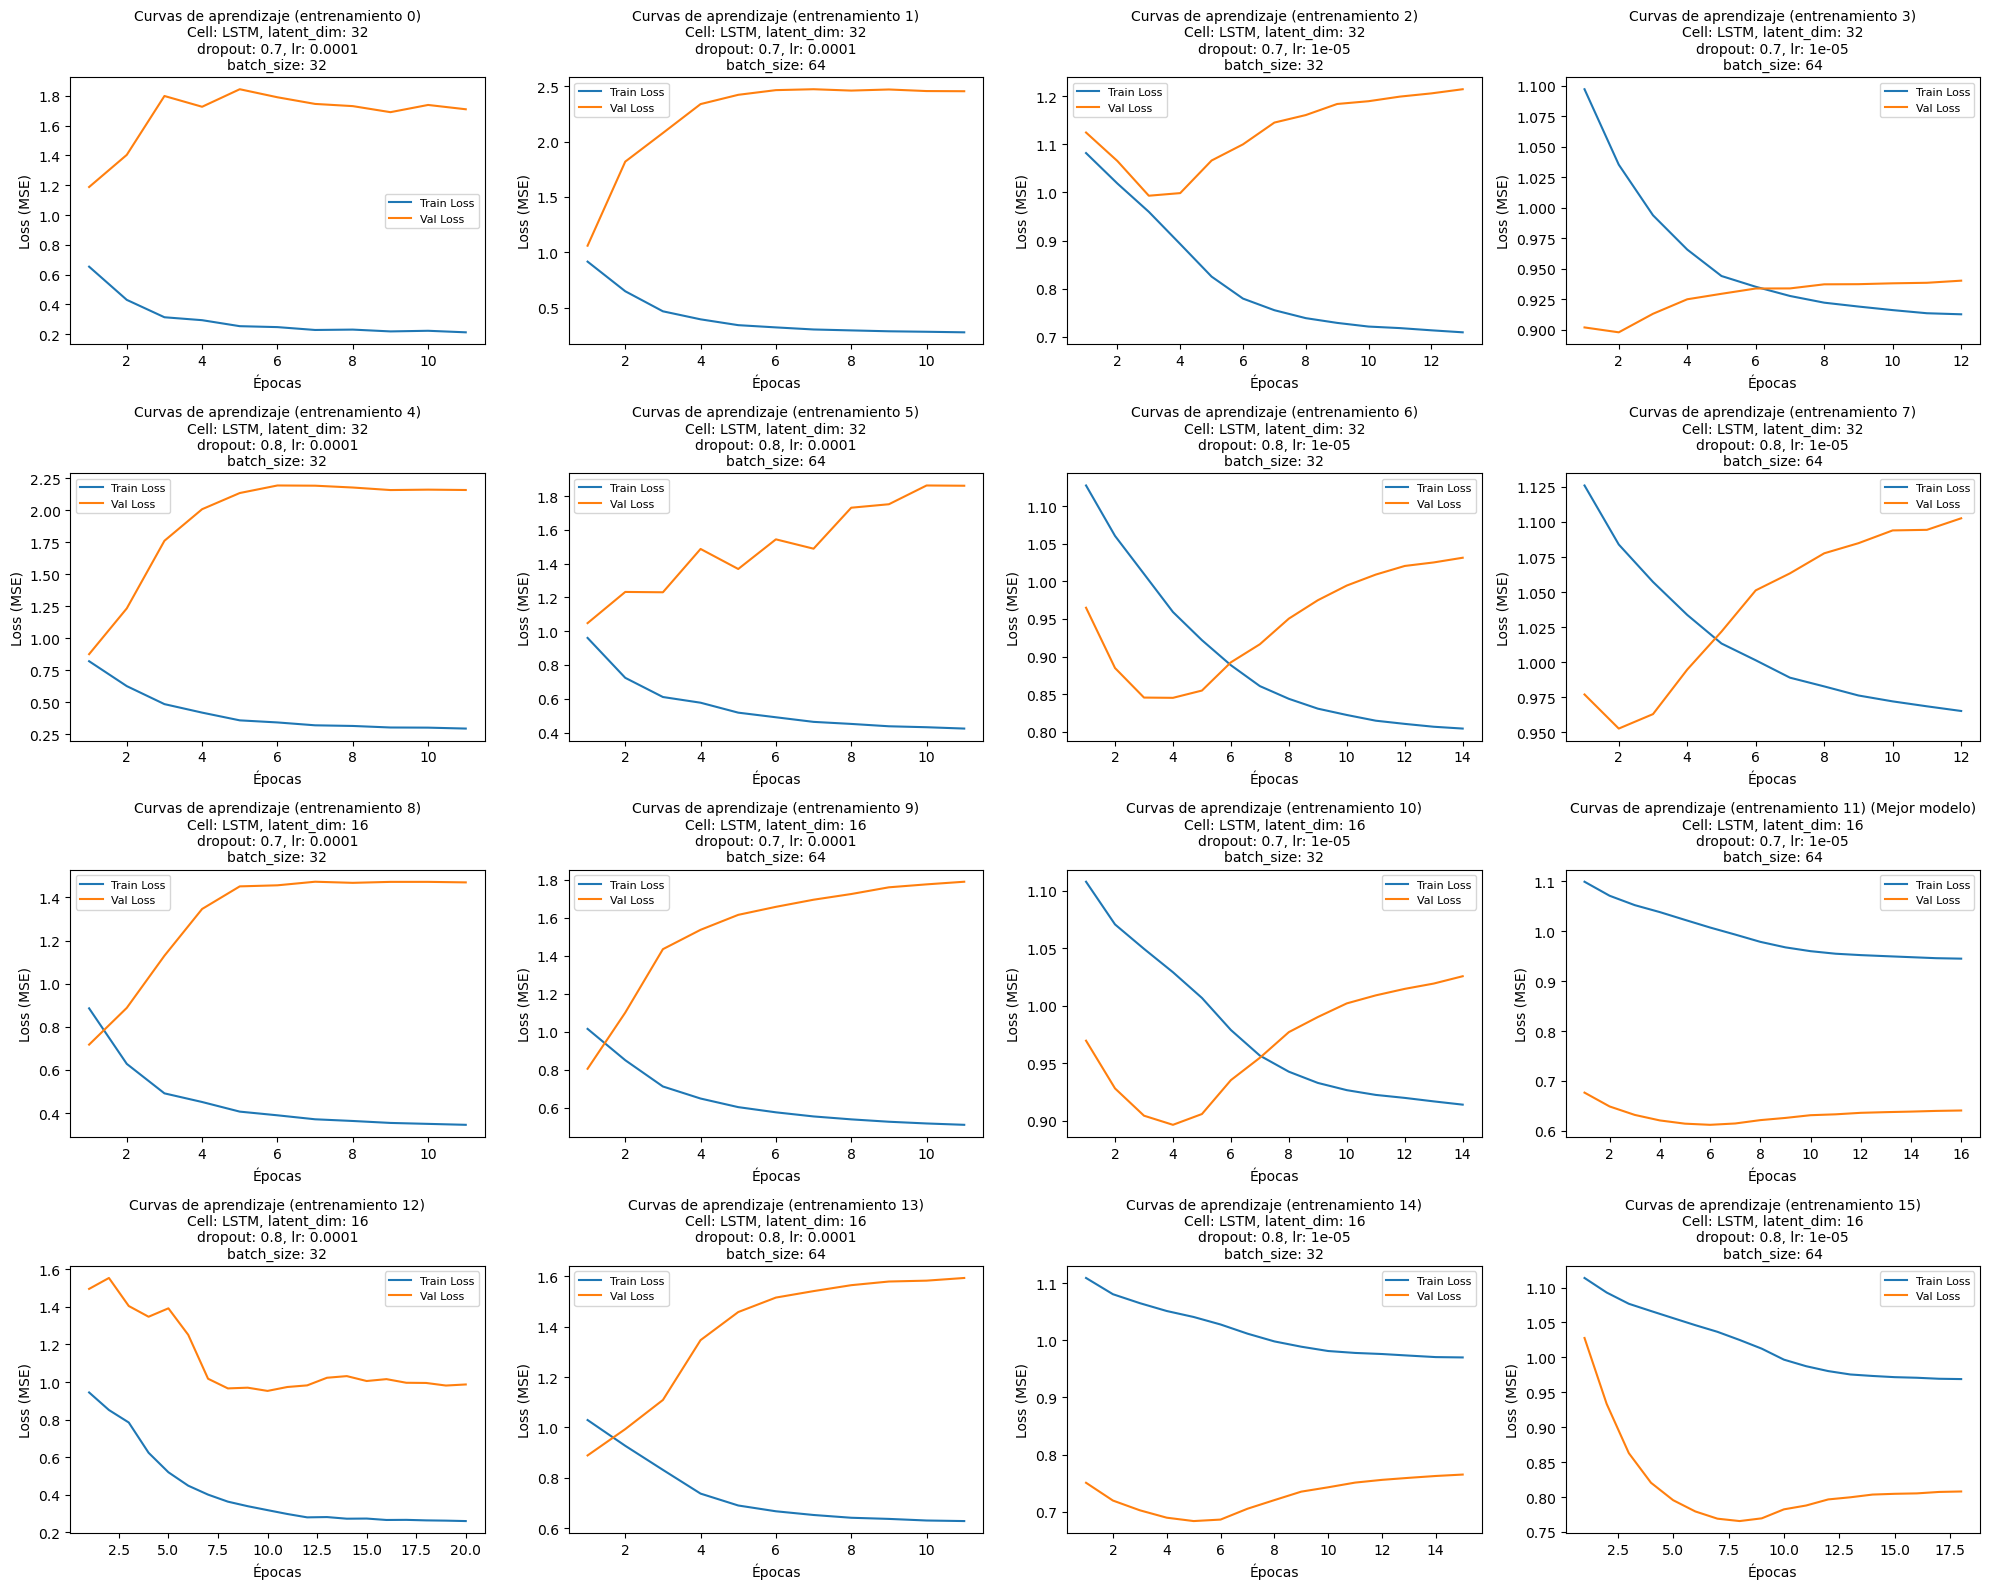

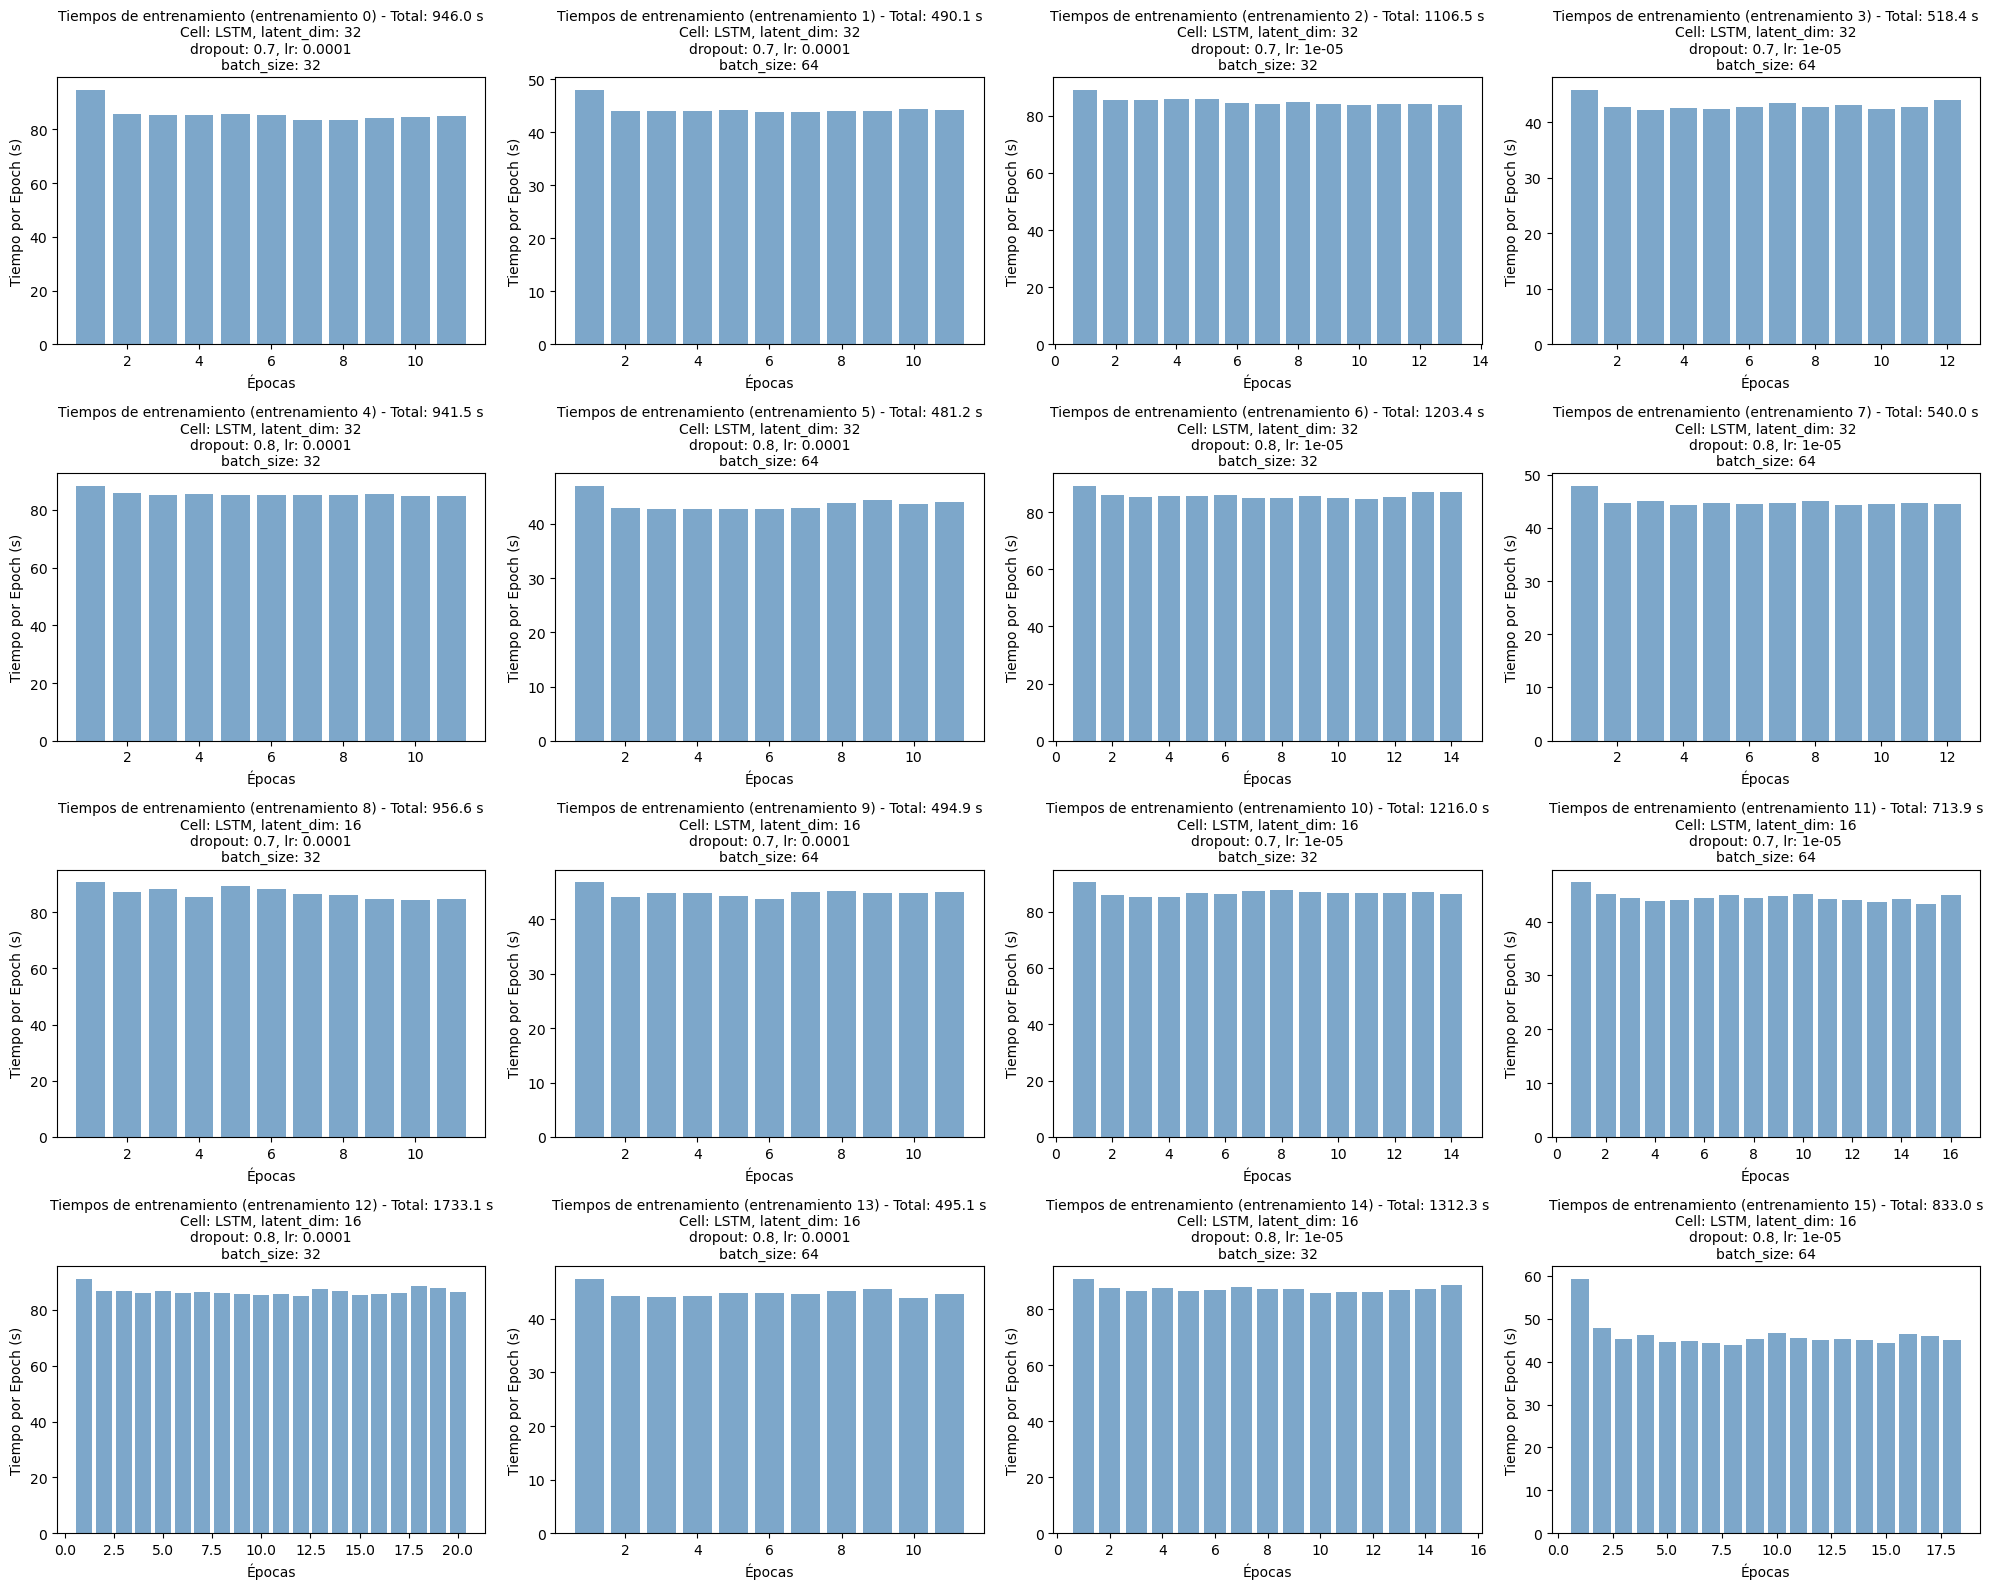

In [6]:
# Graficamos
plot_all_learning_curves(df_results, n=4)
plot_training_times(df_results, n=4)


# Función para imprimir los resultados en tablas

In [7]:
def imprimir_tabla_resultados(df_results, data_dict):
    """
    Muestra una tabla con los valores de df_results excepto 'learning_curve' y 'epoch_times'
    y destaca el mejor modelo en markdown.

    - Los valores decimales se redondean a 4 cifras.
    - 'total_training_time' se calcula como la suma de 'epoch_times'.
    - El mejor modelo es el que tiene el menor 'best_val_mse'.
    - 'learning_rate' se muestra en notación científica con un solo decimal.
    - Si 'predictions_loss["mse"]' está en data_dict, se añade como columna 'test_mse' con 4 decimales.
    """
    # Eliminar la columna 'learning_curve'
    df_display = df_results.drop(columns=['learning_curve'])

    # Calcular 'total_training_time' como la suma de 'epoch_times'
    df_display['total_training_time'] = df_results['epoch_times'].apply(sum).round(4)
    
    # Eliminar la columna 'epoch_times'
    df_display = df_display.drop(columns=['epoch_times'])

    # Redondear valores decimales a 4 cifras
    for col in df_display.select_dtypes(include=['float64', 'float32']):
        if col != 'learning_rate':
            df_display[col] = df_display[col].round(4)
    
    # Formatear 'learning_rate' en notación científica con un decimal
    df_display['learning_rate'] = df_display['learning_rate'].apply(lambda x: f'{x:.1e}')

    # Identificar el mejor modelo (mínimo 'best_val_mse')
    best_model_idx = df_display['best_val_mse'].idxmin()

    # Verificar si existe predictions_loss y contiene mse
    if "predictions_loss" in data_dict and isinstance(data_dict["predictions_loss"], dict):
        test_mse = data_dict["predictions_loss"].get("mse")
        if test_mse is not None:
            # Agregar la columna "test_mse" solo con el valor del mejor modelo
            df_display["test_mse"] = None
            df_display.loc[best_model_idx, "test_mse"] = round(test_mse, 4)

    # Convertir a Markdown destacando el mejor modelo
    markdown_table = df_display.to_markdown(index=True)

    # Resaltar el mejor modelo sin desplazar la salida
    markdown_lines = markdown_table.split("\n")
    header = markdown_lines[0]
    separator = markdown_lines[1]
    data_rows = markdown_lines[2:]

    for i in range(len(data_rows)):
        if i + 2 == best_model_idx + 2:  # Mantener alineación
            data_rows[i] = data_rows[i].replace("|", "|**", 1).rstrip() + "**"

    # Reconstruir la tabla
    markdown_output = "\n".join([header, separator] + data_rows)

    # Mostrar la tabla
    display(Markdown(markdown_output))


In [8]:
print("Resultados GRU")
print("==============")
imprimir_tabla_resultados(df_results, data_dict)

Resultados GRU


|    |   latent_dim |   dropout |   learning_rate |   batch_size | cell_type   |   best_val_mse |   best_val_mse_epoch_idx |   best_train_mse_eval |   best_val_mse_eval |   best_val_mae |   epochs_ran |   total_training_time |   test_mse |
|---:|-------------:|----------:|----------------:|-------------:|:------------|---------------:|-------------------------:|----------------------:|--------------------:|---------------:|-------------:|----------------------:|-----------:|
|  0 |           32 |       0.7 |          0.0001 |           32 | LSTM        |         1.1881 |                        0 |                0.9477 |              1.1881 |         0.8932 |           11 |               943.376 |            |
|  1 |           32 |       0.7 |          0.0001 |           64 | LSTM        |         1.0602 |                        0 |                0.819  |              1.0602 |         0.8423 |           11 |               488.831 |            |
|  2 |           32 |       0.7 |          1e-05  |           32 | LSTM        |         0.9933 |                        2 |                0.9079 |              0.9933 |         0.8387 |           13 |              1105.21  |            |
|  3 |           32 |       0.7 |          1e-05  |           64 | LSTM        |         0.8979 |                        1 |                0.9212 |              0.8979 |         0.7861 |           12 |               516.997 |            |
|  4 |           32 |       0.8 |          0.0001 |           32 | LSTM        |         0.8754 |                        0 |                1.1157 |              0.8754 |         0.7387 |           11 |               940.351 |            |
|  5 |           32 |       0.8 |          0.0001 |           64 | LSTM        |         1.0476 |                        0 |                0.7793 |              1.0476 |         0.8417 |           11 |               479.882 |            |
|  6 |           32 |       0.8 |          1e-05  |           32 | LSTM        |         0.845  |                        3 |                0.998  |              0.845  |         0.7501 |           14 |              1202.1   |            |
|  7 |           32 |       0.8 |          1e-05  |           64 | LSTM        |         0.9528 |                        1 |                0.9015 |              0.9528 |         0.8316 |           12 |               538.615 |            |
|  8 |           16 |       0.7 |          0.0001 |           32 | LSTM        |         0.7173 |                        0 |                0.7197 |              0.7173 |         0.7143 |           11 |               955.4   |            |
|  9 |           16 |       0.7 |          0.0001 |           64 | LSTM        |         0.8051 |                        0 |                0.8087 |              0.8051 |         0.7549 |           11 |               493.513 |            |
| 10 |           16 |       0.7 |          1e-05  |           32 | LSTM        |         0.8965 |                        3 |                0.9635 |              0.8965 |         0.7632 |           14 |              1214.77  |            |
|** 11 |           16 |       0.7 |          1e-05  |           64 | LSTM        |         0.6121 |                        5 |                0.8753 |              0.6121 |         0.6555 |           16 |               712.601 |     1.0816 |**
| 12 |           16 |       0.8 |          0.0001 |           32 | LSTM        |         0.9527 |                        9 |                0.7703 |              0.9527 |         0.7207 |           20 |              1731.78  |            |
| 13 |           16 |       0.8 |          0.0001 |           64 | LSTM        |         0.8886 |                        0 |                0.9355 |              0.8886 |         0.767  |           11 |               493.786 |            |
| 14 |           16 |       0.8 |          1e-05  |           32 | LSTM        |         0.6833 |                        4 |                0.8975 |              0.6833 |         0.7155 |           15 |              1310.81  |            |
| 15 |           16 |       0.8 |          1e-05  |           64 | LSTM        |         0.7656 |                        7 |                0.9347 |              0.7656 |         0.7568 |           18 |               831.347 |            |

In [9]:
class GeneradorResultadosRNN:
    """
    Procesa archivos .joblib con resultados de experimentos (formato:
    prediccion_rnn_direct_(GRU|LSTM)(\d+).joblib). Cada archivo debe contener:
      - 'df_results': DataFrame con resultados.
      - 'predictions_loss': opcional, con clave 'mse'.
    
    La clase agrupa los experimentos por tipo (GRU o LSTM), genera tablas en
    Markdown que muestran todas las filas de 'df_results' y destaca (en negrita)
    la fila con el menor valor de 'best_val_mse_eval'. En esa fila se añade una
    columna 'predictions_loss_mse' con el valor real de 'mse' (formateado a 5 decimales).
    
    Además, se formatean las columnas numéricas a 5 decimales y total_training_time se
    muestra en formato amigable.
    
    Por último, se puede generar un resultado agregado que contiene solo los mejores
    modelos de cada experimento, agregando las columnas 'Experimento' y 'cell_type'.
    
    Si notebook_mode es True, se usa display(Markdown(...)) para renderizar.
    """
    def __init__(self, lista_archivos, notebook_mode=False):
        """
        :param lista_archivos: Lista de rutas (str) a archivos .joblib.
        :param notebook_mode: True para renderizar Markdown en un Notebook.
        """
        self.lista_archivos = lista_archivos
        self.notebook_mode = notebook_mode
        self.patron = re.compile(r"prediccion_rnn_direct_(GRU|LSTM)(\d+)\.joblib")
        self.resultados_por_tipo = {"GRU": [], "LSTM": []}
    
    def generar_resultados(self, mostrar=True):
        """
        Procesa cada archivo .joblib, extrae 'df_results' y 'predictions_loss' (mse),
        agrupa los experimentos por tipo y genera ficheros Markdown con tablas
        que muestran todas las filas de 'df_results', destacando la fila con el
        mejor 'best_val_mse_eval'. Si mostrar=True, renderiza el Markdown.
        """
        for archivo in self.lista_archivos:
            nombre_archivo = os.path.basename(archivo)
            match = self.patron.match(nombre_archivo)
            if not match:
                continue

            tipo_rnn, indice_str = match.groups()
            indice = int(indice_str)

            try:
                data_dict = joblib.load(archivo)
            except Exception as e:
                print(f"[ERROR] No se pudo cargar {archivo}: {e}")
                continue

            df_results = data_dict.get("df_results")
            if not isinstance(df_results, pd.DataFrame) or df_results.empty:
                print(f"[ADVERTENCIA] df_results ausente o vacío en {archivo}")
                continue

            predictions_loss = data_dict.get("predictions_loss", {})
            mse_value = predictions_loss.get("mse", "N/A")

            self.resultados_por_tipo[tipo_rnn].append((indice, df_results, mse_value))

        self._generar_fichero_markdown("GRU", "resultados_GRU.joblib", mostrar)
        self._generar_fichero_markdown("LSTM", "resultados_LSTM.joblib", mostrar)
    
    def _generar_fichero_markdown(self, tipo_rnn, nombre_salida, mostrar):
        """
        Genera un archivo Markdown para el tipo de RNN dado (GRU o LSTM) con tablas
        que muestran los experimentos ordenados por índice.
        """
        resultados = self.resultados_por_tipo[tipo_rnn]
        if not resultados:
            return

        resultados.sort(key=lambda x: x[0])
        with open(nombre_salida, "w", encoding="utf-8") as f_out:
            encabezado = f"# Resultados {tipo_rnn}\n\n"
            f_out.write(encabezado)
            if mostrar:
                if self.notebook_mode:
                    display(Markdown(encabezado))
                else:
                    print(encabezado, end="")

            for indice, df_results, mse_value in resultados:
                subtitulo = f"## Experimento {indice}\n\n"
                f_out.write(subtitulo)
                if mostrar:
                    if self.notebook_mode:
                        display(Markdown(subtitulo))
                    else:
                        print(subtitulo, end="")

                tabla_md = self._formatear_df_en_tabla(df_results, mse_value)
                f_out.write(tabla_md + "\n\n")
                if mostrar:
                    if self.notebook_mode:
                        display(Markdown(tabla_md))
                    else:
                        print(tabla_md + "\n")
    
    def _formatear_df_en_tabla(self, df, mse_value):
        """
        Convierte el DataFrame en una cadena Markdown que representa una tabla.
        Destaca en negrita la fila con el menor 'best_val_mse_eval'. Añade la columna
        'predictions_loss_mse' con el valor de mse en la fila destacada (formateado a 5 decimales)
        y "N/A" en el resto. Además, formatea las columnas numéricas indicadas a 5 decimales y
        total_training_time a un formato amigable.
        """
        columnas_interes = [
            "latent_dim", "dropout", "learning_rate", "batch_size",
            "best_val_mse_epoch_idx", "best_train_mse_eval", "best_val_mse_eval",
            "best_val_mae", "epochs_ran", "total_training_time"
        ]
        idx_mejor = df["best_val_mse_eval"].idxmin() if "best_val_mse_eval" in df.columns else None
        columnas_finales = columnas_interes + ["predictions_loss_mse"]

        header = "|" + "|".join(columnas_finales) + "|"
        separador = "|" + "|".join(["---"] * len(columnas_finales)) + "|"
        lineas = [header, separador]

        for i, row in df.iterrows():
            celdas = []
            for col in columnas_interes:
                if col not in df.columns:
                    valor_str = "N/A"
                else:
                    valor = row[col]
                    if col in {"best_train_mse_eval", "best_val_mse_eval", "best_val_mae"}:
                        try:
                            valor_str = f"{float(valor):.5f}"
                        except Exception:
                            valor_str = str(valor)
                    elif col == "total_training_time":
                        valor_str = self._format_time(valor)
                    else:
                        valor_str = str(valor)
                if i == idx_mejor:
                    valor_str = f"**{valor_str}**"
                celdas.append(valor_str)
            if i == idx_mejor:
                if mse_value != "N/A":
                    try:
                        valor_mse_str = f"**{float(mse_value):.5f}**"
                    except Exception:
                        valor_mse_str = f"**{mse_value}**"
                else:
                    valor_mse_str = "**N/A**"
            else:
                valor_mse_str = "N/A"
            celdas.append(valor_mse_str)
            lineas.append("|" + "|".join(str(v) for v in celdas) + "|")
        return "\n".join(lineas)
    
    def _format_time(self, seconds):
        """
        Convierte un tiempo en segundos a un formato más amigable: 'Xh Ym Zs.ss'.
        """
        try:
            seconds = float(seconds)
        except Exception:
            return str(seconds)
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = seconds % 60
        return f"{hours}h {minutes}m {secs:.2f}s"
    
    def generar_resultado_agregado(self, mostrar=True):
        """
        Genera una tabla agregada con una fila por experimento (sólo el mejor modelo de cada uno).
        Se añade una columna 'Experimento' y 'cell_type', y se muestran las demás columnas formateadas.
        Se incorpora un título que diferencia este resultado del resto.
        La tabla se renderiza en Markdown y se guarda en 'resultado_agregado.joblib'.
        """
        agregados = []
        for cell_type, lista in self.resultados_por_tipo.items():
            for indice, df_results, mse_value in lista:
                if "best_val_mse_eval" not in df_results.columns:
                    continue
                idx_mejor = df_results["best_val_mse_eval"].idxmin()
                best_row = df_results.loc[idx_mejor]
                fila = {
                    "Experimento": indice,
                    "cell_type": best_row.get("cell_type", cell_type)
                }
                cols = ["latent_dim", "dropout", "learning_rate", "batch_size",
                        "best_val_mse_epoch_idx", "best_train_mse_eval", "best_val_mse_eval",
                        "best_val_mae", "epochs_ran", "total_training_time"]
                for col in cols:
                    if col not in best_row:
                        fila[col] = "N/A"
                    else:
                        val = best_row[col]
                        if col in {"best_train_mse_eval", "best_val_mse_eval", "best_val_mae"}:
                            try:
                                fila[col] = f"{float(val):.5f}"
                            except Exception:
                                fila[col] = str(val)
                        elif col == "total_training_time":
                            fila[col] = self._format_time(val)
                        else:
                            fila[col] = val
                if mse_value != "N/A":
                    try:
                        fila["predictions_loss_mse"] = f"{float(mse_value):.5f}"
                    except Exception:
                        fila["predictions_loss_mse"] = str(mse_value)
                else:
                    fila["predictions_loss_mse"] = "N/A"
                agregados.append(fila)
        if agregados:
            df_agregado = pd.DataFrame(agregados)
            cols_orden = ["Experimento", "cell_type", "latent_dim", "dropout", "learning_rate", "batch_size",
                          "best_val_mse_epoch_idx", "best_train_mse_eval", "best_val_mse_eval",
                          "best_val_mae", "epochs_ran", "total_training_time", "predictions_loss_mse"]
            df_agregado = df_agregado[cols_orden]
            # Agregar un título al resultado agregado
            titulo = "# Resultado Agregado de los Mejores Modelos\n\n"
            markdown_table = titulo + df_agregado.to_markdown(index=False)
            if mostrar:
                if self.notebook_mode:
                    display(Markdown(markdown_table))
                else:
                    print(markdown_table)
            with open("resultado_agregado.joblib", "w", encoding="utf-8") as f:
                f.write(markdown_table)
        else:
            print("No se encontraron resultados agregados.")


In [10]:
FIC_ENTRADA=[ 'prediccion_rnn_direct_GRU1.joblib',  'prediccion_rnn_direct_GRU2.joblib',
             'prediccion_rnn_direct_GRU3.joblib',  'prediccion_rnn_direct_GRU4.joblib',
             'prediccion_rnn_direct_GRU5.joblib',  'prediccion_rnn_direct_GRU6.joblib',
             'prediccion_rnn_direct_GRU7.joblib', 
             'prediccion_rnn_direct_LSTM1.joblib', 'prediccion_rnn_direct_LSTM2.joblib',
             'prediccion_rnn_direct_LSTM3.joblib', 'prediccion_rnn_direct_LSTM4.joblib',
             'prediccion_rnn_direct_LSTM5.joblib' ]
resultados = GeneradorResultadosRNN(FIC_ENTRADA, notebook_mode=True)
resultados.generar_resultados(mostrar=True)
resultados.generar_resultado_agregado(mostrar=True)

[ERROR] No se pudo cargar prediccion_rnn_direct_GRU4.joblib: [Errno 2] No such file or directory: 'prediccion_rnn_direct_GRU4.joblib'


# Resultados GRU



## Experimento 1



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|32|0.7|0.0001|32|0|1.22232|0.88831|0.75680|11|0h 14m 30.51s|N/A|
|32|0.7|0.0001|64|0|1.01688|0.76239|0.70258|11|0h 7m 39.00s|N/A|
|**32**|**0.7**|**1e-05**|**32**|**10**|**0.94710**|**0.66417**|**0.70236**|**21**|**0h 28m 25.71s**|**0.86767**|
|32|0.7|1e-05|64|13|0.94780|0.73031|0.75001|24|0h 16m 20.00s|N/A|
|32|0.8|0.0001|32|0|1.14187|0.90243|0.80608|11|0h 14m 34.75s|N/A|
|32|0.8|0.0001|64|1|1.05739|0.78920|0.74938|12|0h 8m 18.27s|N/A|
|32|0.8|1e-05|32|10|1.09345|0.79495|0.75303|21|0h 27m 47.26s|N/A|
|32|0.8|1e-05|64|27|1.17741|0.76426|0.74036|38|0h 25m 48.87s|N/A|
|16|0.7|0.0001|32|0|0.94218|0.68798|0.69971|11|0h 14m 37.37s|N/A|
|16|0.7|0.0001|64|0|1.03664|0.78644|0.74290|11|0h 7m 30.78s|N/A|
|16|0.7|1e-05|32|31|0.91359|0.71304|0.72109|42|0h 56m 15.96s|N/A|
|16|0.7|1e-05|64|14|0.98825|0.78288|0.73247|25|0h 17m 19.69s|N/A|
|16|0.8|0.0001|32|0|1.10645|0.87319|0.78489|11|0h 14m 51.96s|N/A|
|16|0.8|0.0001|64|1|1.07309|0.80149|0.76429|12|0h 8m 23.57s|N/A|
|16|0.8|1e-05|32|0|1.11415|0.72079|0.69535|11|0h 14m 58.69s|N/A|
|16|0.8|1e-05|64|1|1.10924|0.72336|0.71077|12|0h 8m 25.41s|N/A|

## Experimento 2



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|32|0.5|0.0001|32|0|1.16865|1.13937|0.88756|7|0h 9m 57.24s|N/A|
|32|0.5|0.0001|64|1|0.77467|0.84204|0.74869|8|0h 5m 37.49s|N/A|
|32|0.5|1e-05|32|6|0.86159|0.76419|0.75018|13|0h 18m 21.77s|N/A|
|32|0.5|1e-05|64|4|0.96937|0.79312|0.78848|11|0h 8m 3.07s|N/A|
|32|0.7|0.0001|32|0|1.07757|0.68098|0.71229|7|0h 9m 48.93s|N/A|
|32|0.7|0.0001|64|0|1.02979|0.71671|0.73769|7|0h 5m 6.76s|N/A|
|32|0.7|1e-05|32|0|1.02907|0.83390|0.79898|7|0h 9m 51.16s|N/A|
|32|0.7|1e-05|64|7|1.05524|0.81660|0.75111|14|0h 10m 9.29s|N/A|
|16|0.5|0.0001|32|0|1.01858|0.83136|0.74423|7|0h 9m 47.71s|N/A|
|16|0.5|0.0001|64|0|0.96563|0.91512|0.81317|7|0h 5m 9.08s|N/A|
|**16**|**0.5**|**1e-05**|**32**|**12**|**0.91988**|**0.64337**|**0.65493**|**19**|**0h 26m 30.02s**|**1.00533**|
|16|0.5|1e-05|64|14|0.93596|0.90544|0.82305|21|0h 15m 41.41s|N/A|
|16|0.7|0.0001|32|0|1.01536|0.76759|0.74160|7|0h 10m 21.27s|N/A|
|16|0.7|0.0001|64|1|0.92456|0.65676|0.70151|8|0h 6m 15.22s|N/A|
|16|0.7|1e-05|32|24|0.92614|0.64460|0.68581|31|0h 46m 56.21s|N/A|
|16|0.7|1e-05|64|33|0.90727|0.73395|0.74679|40|0h 30m 42.58s|N/A|

## Experimento 3



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|32|0.3|1e-05|32|3|1.13379|1.06193|0.83920|10|0h 13m 14.93s|N/A|
|32|0.4|1e-05|32|1|1.05970|1.00010|0.82491|8|0h 10m 17.63s|N/A|
|**64**|**0.3**|**1e-05**|**32**|**1**|**0.91098**|**0.90410**|**0.76826**|**8**|**0h 10m 9.62s**|**1.02344**|
|64|0.4|1e-05|32|1|0.89345|1.03486|0.84463|8|0h 10m 12.23s|N/A|

## Experimento 5



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|**64**|**0.7**|**1e-05**|**16**|**3**|**0.95490**|**0.66942**|**0.70362**|**10**|**0h 28m 18.89s**|**1.03168**|
|64|0.7|1e-05|32|4|0.91467|0.72918|0.73841|11|0h 15m 46.63s|N/A|

## Experimento 6



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|64|0.7|6.5e-05|16|9|1.23525|1.19636|0.85818|16|0h 43m 41.42s|N/A|
|**64**|**0.7**|**6.5e-05**|**32**|**0**|**1.28074**|**0.97612**|**0.84254**|**7**|**0h 9m 59.86s**|**1.63807**|

## Experimento 7



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|64|0.7|5e-05|16|21|0.92086|1.11425|0.84548|28|1h 18m 16.19s|N/A|
|**64**|**0.7**|**5e-05**|**32**|**0**|**0.97608**|**0.89246**|**0.80696**|**7**|**0h 10m 2.12s**|**1.02634**|

# Resultados LSTM



## Experimento 1



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|32|0.7|0.0001|32|0|0.94771|1.18810|0.89319|11|0h 15m 46.01s|N/A|
|32|0.7|0.0001|64|0|0.81896|1.06020|0.84232|11|0h 8m 10.11s|N/A|
|32|0.7|1e-05|32|2|0.90794|0.99330|0.83868|13|0h 18m 26.53s|N/A|
|32|0.7|1e-05|64|1|0.92117|0.89791|0.78606|12|0h 8m 38.36s|N/A|
|32|0.8|0.0001|32|0|1.11574|0.87538|0.73868|11|0h 15m 41.54s|N/A|
|32|0.8|0.0001|64|0|0.77931|1.04765|0.84168|11|0h 8m 1.18s|N/A|
|32|0.8|1e-05|32|3|0.99795|0.84495|0.75005|14|0h 20m 3.36s|N/A|
|32|0.8|1e-05|64|1|0.90155|0.95278|0.83163|12|0h 8m 59.95s|N/A|
|16|0.7|0.0001|32|0|0.71968|0.71734|0.71430|11|0h 15m 56.65s|N/A|
|16|0.7|0.0001|64|0|0.80870|0.80508|0.75495|11|0h 8m 14.91s|N/A|
|16|0.7|1e-05|32|3|0.96346|0.89646|0.76322|14|0h 20m 15.98s|N/A|
|**16**|**0.7**|**1e-05**|**64**|**5**|**0.87530**|**0.61210**|**0.65554**|**16**|**0h 11m 53.87s**|**1.08163**|
|16|0.8|0.0001|32|9|0.77032|0.95266|0.72066|20|0h 28m 53.13s|N/A|
|16|0.8|0.0001|64|0|0.93546|0.88861|0.76698|11|0h 8m 15.12s|N/A|
|16|0.8|1e-05|32|4|0.89752|0.68331|0.71548|15|0h 21m 52.31s|N/A|
|16|0.8|1e-05|64|7|0.93471|0.76562|0.75680|18|0h 13m 52.95s|N/A|

## Experimento 2



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|32|0.5|0.0001|32|0|0.95569|0.98405|0.74589|7|0h 10m 18.29s|N/A|
|32|0.5|0.0001|64|0|0.74396|0.90884|0.77937|7|0h 5m 5.22s|N/A|
|32|0.5|1e-05|32|3|0.66151|0.69553|0.64458|10|0h 14m 17.22s|N/A|
|32|0.5|1e-05|64|2|0.84905|0.78652|0.72465|9|0h 6m 37.83s|N/A|
|32|0.6|0.0001|32|0|0.88122|0.92479|0.80589|7|0h 9m 56.27s|N/A|
|32|0.6|0.0001|64|0|0.80161|0.92959|0.74757|7|0h 5m 10.90s|N/A|
|32|0.6|1e-05|32|1|0.85687|0.78543|0.75055|8|0h 11m 28.50s|N/A|
|32|0.6|1e-05|64|0|0.96738|0.81424|0.75647|7|0h 4m 48.09s|N/A|
|16|0.5|0.0001|32|0|0.84972|0.91307|0.79259|7|0h 9m 38.63s|N/A|
|16|0.5|0.0001|64|1|0.75544|0.77789|0.75177|8|0h 5m 37.57s|N/A|
|16|0.5|1e-05|32|2|1.07270|1.04055|0.82772|9|0h 12m 31.34s|N/A|
|16|0.5|1e-05|64|1|1.02972|1.00900|0.80044|8|0h 5m 43.07s|N/A|
|16|0.6|0.0001|32|0|1.04833|1.34629|0.91443|7|0h 9m 50.85s|N/A|
|16|0.6|0.0001|64|0|1.01257|1.08778|0.76722|7|0h 5m 10.86s|N/A|
|**16**|**0.6**|**1e-05**|**32**|**8**|**0.82430**|**0.64432**|**0.68475**|**15**|**0h 21m 0.68s**|**1.05884**|
|16|0.6|1e-05|64|2|0.99985|0.93622|0.81741|9|0h 6m 35.88s|N/A|

## Experimento 3



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|32|0.3|1e-05|32|0|0.95069|0.85984|0.78464|7|0h 9m 44.12s|N/A|
|32|0.4|1e-05|32|0|1.02312|0.91948|0.76229|7|0h 9m 46.32s|N/A|
|64|0.3|1e-05|32|0|0.83696|1.11774|0.85224|7|0h 10m 6.65s|N/A|
|**64**|**0.4**|**1e-05**|**32**|**0**|**0.82810**|**0.62653**|**0.64043**|**7**|**0h 9m 59.57s**|**1.02109**|

## Experimento 4



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|**64**|**0.6**|**1e-05**|**32**|**0**|**0.77307**|**0.64520**|**0.65185**|**7**|**0h 9m 36.82s**|**0.86787**|
|128|0.6|1e-05|32|0|0.67467|0.74745|0.68028|7|0h 11m 4.63s|N/A|

## Experimento 5



|latent_dim|dropout|learning_rate|batch_size|best_val_mse_epoch_idx|best_train_mse_eval|best_val_mse_eval|best_val_mae|epochs_ran|total_training_time|predictions_loss_mse|
|---|---|---|---|---|---|---|---|---|---|---|
|64|0.7|1e-05|16|0|0.71995|0.93013|0.73649|7|0h 20m 34.53s|N/A|
|**64**|**0.7**|**1e-05**|**32**|**0**|**0.75332**|**0.83825**|**0.77081**|**7**|**0h 10m 35.11s**|**1.04005**|

# Resultado Agregado de los Mejores Modelos

|   Experimento | cell_type   |   latent_dim |   dropout |   learning_rate |   batch_size |   best_val_mse_epoch_idx |   best_train_mse_eval |   best_val_mse_eval |   best_val_mae |   epochs_ran | total_training_time   |   predictions_loss_mse |
|--------------:|:------------|-------------:|----------:|----------------:|-------------:|-------------------------:|----------------------:|--------------------:|---------------:|-------------:|:----------------------|-----------------------:|
|             1 | GRU         |           32 |       0.7 |         1e-05   |           32 |                       10 |               0.9471  |             0.66417 |        0.70236 |           21 | 0h 28m 25.71s         |                0.86767 |
|             2 | GRU         |           16 |       0.5 |         1e-05   |           32 |                       12 |               0.91988 |             0.64337 |        0.65493 |           19 | 0h 26m 30.02s         |                1.00533 |
|             3 | GRU         |           64 |       0.3 |         1e-05   |           32 |                        1 |               0.91098 |             0.9041  |        0.76826 |            8 | 0h 10m 9.62s          |                1.02344 |
|             5 | GRU         |           64 |       0.7 |         1e-05   |           16 |                        3 |               0.9549  |             0.66942 |        0.70362 |           10 | 0h 28m 18.89s         |                1.03168 |
|             6 | GRU         |           64 |       0.7 |         6.5e-05 |           32 |                        0 |               1.28074 |             0.97612 |        0.84254 |            7 | 0h 9m 59.86s          |                1.63807 |
|             7 | GRU         |           64 |       0.7 |         5e-05   |           32 |                        0 |               0.97608 |             0.89246 |        0.80696 |            7 | 0h 10m 2.12s          |                1.02634 |
|             1 | LSTM        |           16 |       0.7 |         1e-05   |           64 |                        5 |               0.8753  |             0.6121  |        0.65554 |           16 | 0h 11m 53.87s         |                1.08163 |
|             2 | LSTM        |           16 |       0.6 |         1e-05   |           32 |                        8 |               0.8243  |             0.64432 |        0.68475 |           15 | 0h 21m 0.68s          |                1.05884 |
|             3 | LSTM        |           64 |       0.4 |         1e-05   |           32 |                        0 |               0.8281  |             0.62653 |        0.64043 |            7 | 0h 9m 59.57s          |                1.02109 |
|             4 | LSTM        |           64 |       0.6 |         1e-05   |           32 |                        0 |               0.77307 |             0.6452  |        0.65185 |            7 | 0h 9m 36.82s          |                0.86787 |
|             5 | LSTM        |           64 |       0.7 |         1e-05   |           32 |                        0 |               0.75332 |             0.83825 |        0.77081 |            7 | 0h 10m 35.11s         |                1.04005 |